# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata
import networkx as nx




# Global

In [2]:
df = pd.read_csv("data/q2/Wiki-Vote.txt", sep='\t', comment='#', header=None, names=['source', 'target'])
G = nx.DiGraph()
G.add_edges_from(df.itertuples(index=False, name=None))
nodes = list(G.nodes())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 7115
Number of edges: 103689


# Part A

In [3]:
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)
pageranks = nx.pagerank(G, alpha=0.85)
auth_ranks = rankdata([-s for s in authorities.values()], method='ordinal')
pr_ranks = rankdata([-s for s in pageranks.values()], method='ordinal')
node_ranks = {node: (auth_ranks[i], pr_ranks[i]) for i, node in enumerate(G.nodes())}



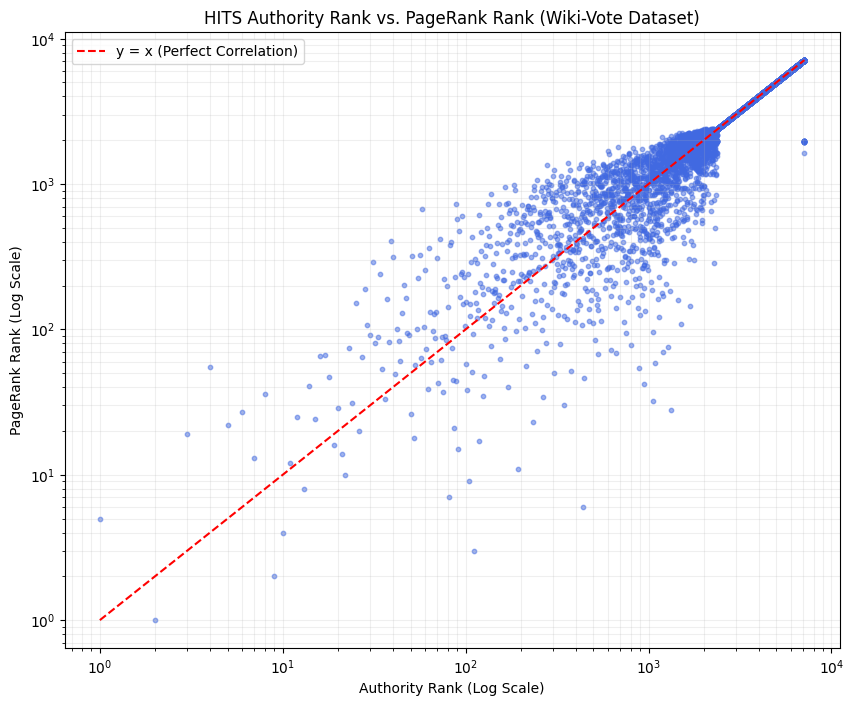

In [4]:
plt.figure(figsize=(10, 8))
plt.scatter(auth_ranks, pr_ranks, alpha=0.5, s=10, color='royalblue')
plt.xscale('log')
plt.yscale('log')

max_r = max(max(auth_ranks), max(pr_ranks))
plt.plot([1, max_r], [1, max_r], color='red', linestyle='--', label='y = x (Perfect Correlation)')

plt.xlabel('Authority Rank (Log Scale)')
plt.ylabel('PageRank Rank (Log Scale)')
plt.title('HITS Authority Rank vs. PageRank Rank (Wiki-Vote Dataset)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()


In [5]:
rank_diff = {node: pr - auth for node, (auth, pr) in node_ranks.items()}
top_pr = sorted(rank_diff.items(), key=lambda x: -x[1])[:5]
top_auth = sorted(rank_diff.items(), key=lambda x: x[1])[:5]

print("Top nodes with PageRank >> HITS:", top_pr)
print("Top nodes with HITS >> PageRank:", top_auth)


node = top_pr[0][0]  # Example node with high PageRank vs HITS
print("In-degree:", G.in_degree(node))
print("Out-degree:", G.out_degree(node))
print("Nodes pointing to this node:", list(G.predecessors(node)))


Top nodes with PageRank >> HITS: [(5132, np.int64(1106)), (1733, np.int64(1083)), (5637, np.int64(1068)), (2605, np.int64(1029)), (4482, np.int64(1014))]
Top nodes with HITS >> PageRank: [(7033, np.int64(-5492)), (3245, np.int64(-5156)), (4541, np.int64(-5152)), (3195, np.int64(-5151)), (2365, np.int64(-5149))]
In-degree: 33
Out-degree: 0
Nodes pointing to this node: [11, 737, 766, 816, 841, 1166, 1847, 1922, 2565, 2658, 2688, 2871, 2967, 2972, 3352, 3449, 3452, 3456, 3615, 3660, 3813, 4045, 4077, 4076, 4219, 4222, 4441, 4563, 4725, 4899, 5006, 5110, 5119]


=== CATEGORY 1: HITS Authority >> PageRank ===

Node 5132 | Auth Rank: 684 | PR Rank: 1790
{'In-Degree': 33, 'Avg Out-Degree of Preds': np.float64(236.0), 'Avg Hub Score of Preds': np.float64(0.002377), 'Avg PageRank of Preds': np.float64(0.000385)}

Node 1733 | Auth Rank: 600 | PR Rank: 1683
{'In-Degree': 39, 'Avg Out-Degree of Preds': np.float64(217.38), 'Avg Hub Score of Preds': np.float64(0.002196), 'Avg PageRank of Preds': np.float64(0.00026)}

Node 5637 | Auth Rank: 279 | PR Rank: 1347
{'In-Degree': 58, 'Avg Out-Degree of Preds': np.float64(196.59), 'Avg Hub Score of Preds': np.float64(0.002035), 'Avg PageRank of Preds': np.float64(0.000325)}

=== CATEGORY 2: PageRank >> HITS Authority ===

Node 7033 | PR Rank: 1623 | Auth Rank: 7115
{'In-Degree': 2, 'Avg Out-Degree of Preds': np.float64(1.0), 'Avg Hub Score of Preds': np.float64(-0.0), 'Avg PageRank of Preds': np.float64(5e-05)}

Node 3245 | PR Rank: 1957 | Auth Rank: 7113
{'In-Degree': 1, 'Avg Out-Degree of Preds': np.float64(1

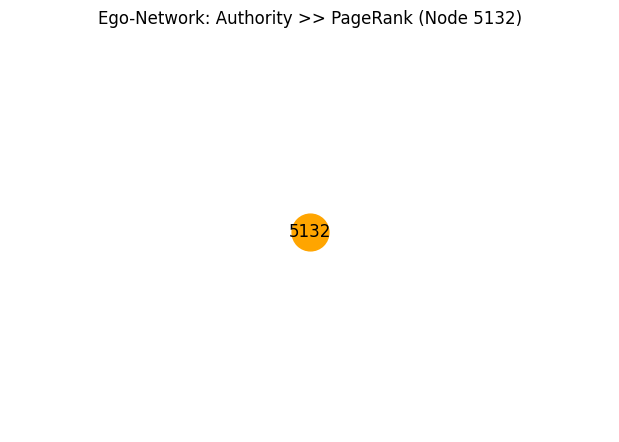

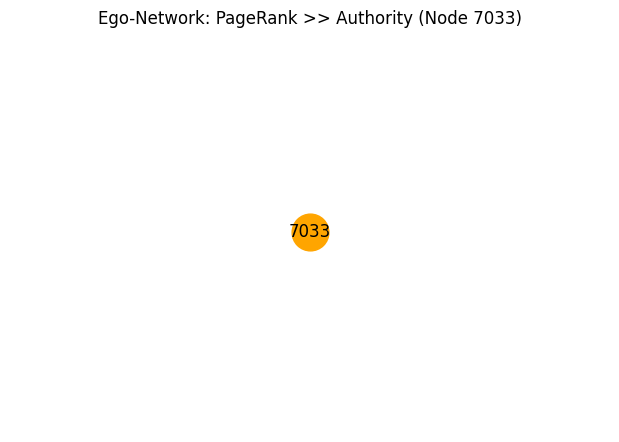

In [6]:

# Top 3 where Authority Rank is much better than PageRank (Authority >> PageRank)
top_auth_outliers = sorted(rank_diff.items(), key=lambda x: x[1], reverse=True)[:3]

# Top 3 where PageRank Rank is much better than Authority (PageRank >> Authority)
top_pr_outliers = sorted(rank_diff.items(), key=lambda x: x[1])[:3]

def analyze_structure(node_id):
    preds = list(G.predecessors(node_id))
    if not preds:
        return "No incoming links."
    
    avg_out_degree_preds = np.mean([G.out_degree(p) for p in preds])
    avg_hub_score_preds = np.mean([hubs[p] for p in preds])
    avg_pr_score_preds = np.mean([pageranks[p] for p in preds])
    
    return {
        "In-Degree": G.in_degree(node_id),
        "Avg Out-Degree of Preds": round(avg_out_degree_preds, 2),
        "Avg Hub Score of Preds": round(avg_hub_score_preds, 6),
        "Avg PageRank of Preds": round(avg_pr_score_preds, 6)
    }

# 3. Print Results for Reporting
print("=== CATEGORY 1: HITS Authority >> PageRank ===")
for node, diff in top_auth_outliers:
    idx = nodes.index(node)
    print(f"\nNode {node} | Auth Rank: {auth_ranks[idx]} | PR Rank: {pr_ranks[idx]}")
    print(analyze_structure(node))

print("\n=== CATEGORY 2: PageRank >> HITS Authority ===")
for node, diff in top_pr_outliers:
    idx = nodes.index(node)
    print(f"\nNode {node} | PR Rank: {pr_ranks[idx]} | Auth Rank: {auth_ranks[idx]}")
    print(analyze_structure(node))

# 4. Visualization of Outliers (Ego Networks)
def plot_ego(node_id, title):
    ego = nx.ego_graph(G, node_id, radius=1, center=True, undirected=False)
    pos = nx.spring_layout(ego)
    plt.figure(figsize=(6, 4))
    nx.draw(ego, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', arrowsize=15)
    nx.draw_networkx_nodes(ego, pos, nodelist=[node_id], node_color='orange', node_size=700)
    plt.title(title)
    plt.show()

# Visualize the most extreme outlier from each group
plot_ego(top_auth_outliers[0][0], f"Ego-Network: Authority >> PageRank (Node {top_auth_outliers[0][0]})")
plot_ego(top_pr_outliers[0][0], f"Ego-Network: PageRank >> Authority (Node {top_pr_outliers[0][0]})")

# Part B

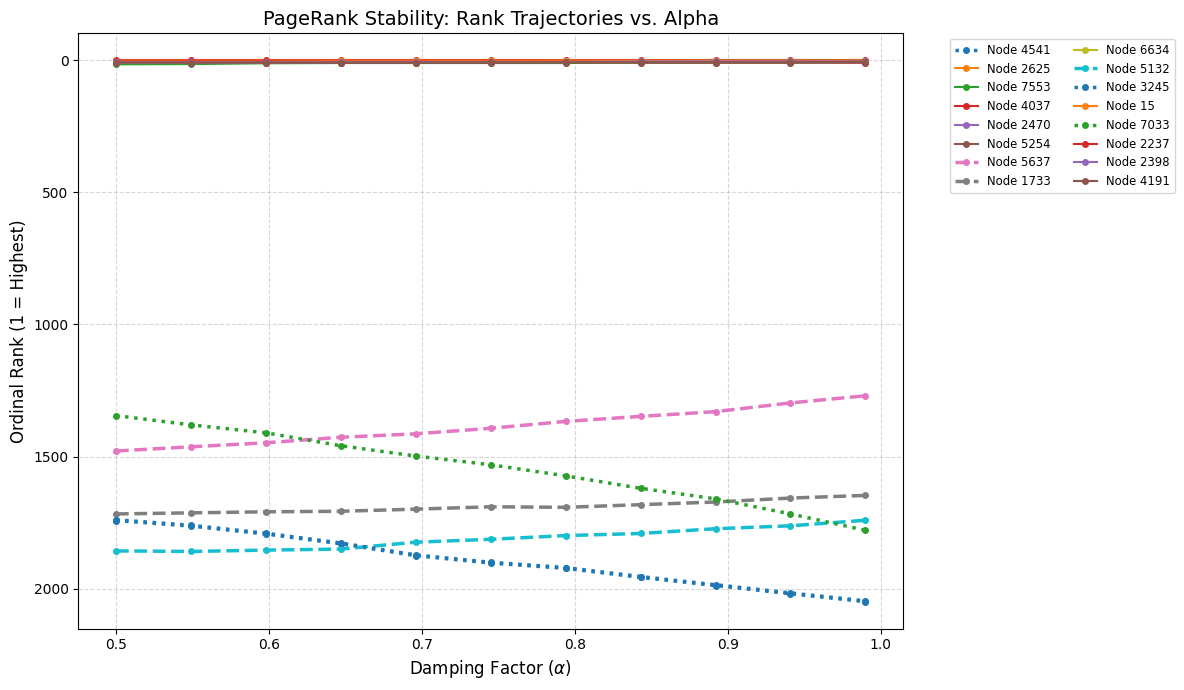

In [21]:
import numpy as np
import networkx as nx
from scipy.stats import rankdata
import matplotlib.pyplot as plt

alphas = np.linspace(0.50, 0.99, 11)
reference_pr = nx.pagerank(G, alpha=0.85)
top_10_nodes = sorted(reference_pr, key=reference_pr.get, reverse=True)[:10]
anomalies_c1 = [5132, 5637, 1733]
anomalies_c2 = [7033, 3245, 4541]

target_nodes = list(set(top_10_nodes + anomalies_c1 + anomalies_c2))
rank_trajectories = {node: [] for node in target_nodes}

for a in alphas:
    pr_scores = nx.pagerank(G, alpha=a)
    ranks = rankdata([-s for s in pr_scores.values()], method='ordinal')
    node_to_rank = dict(zip(pr_scores.keys(), ranks))
    
    for node in target_nodes:
        rank_trajectories[node].append(node_to_rank[node])

# 3. Visualization
plt.figure(figsize=(12, 7))
all_anomalies = anomalies_c1 + anomalies_c2
for node in target_nodes:
    if node in top_10_nodes:
        style = '-'
    elif node in anomalies_c1:
        style = '--'
    elif node in anomalies_c2:
        style = ':'
    else:
        style = '-.'
    
    linewidth = 2.5 if node in all_anomalies else 1.5
    
    plt.plot(alphas, rank_trajectories[node], label=f'Node {node}', 
             linestyle=style, linewidth=linewidth, marker='o', markersize=4)

plt.gca().invert_yaxis()  # Rank 1 should be at the top
plt.xlabel(r'Damping Factor ($\alpha$)', fontsize=12)
plt.ylabel('Ordinal Rank (1 = Highest)', fontsize=12)
plt.title('PageRank Stability: Rank Trajectories vs. Alpha', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
